In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
import pathlib

In [4]:
# data_dir = pathlib.Path('../projekat/handwritten/dataset')

In [5]:
# import splitfolders
# splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [2]:
train_path = "./output/train"
test_path  = "./output/test"
val_path = "./output/val"

In [3]:
import os
import pandas as pd
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.image import imread 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
%matplotlib inline

In [4]:
image_shape = (100,100,3)
epochs = 8
batch_size = 32

In [5]:
def bitwise_invert(image):
    temp = tf.image.rgb_to_grayscale(255 -
    image)
    # temp = np.abs(255 - temp)
    temp = tf.image.grayscale_to_rgb(temp)
    #temp = np.abs(255 - image)
    return temp


traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1.0/255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                              zoom_range=0.1,
                             fill_mode='nearest',
                             preprocessing_function=bitwise_invert
                              )

testdata_gen=ImageDataGenerator(
                                rescale=1.0/255,
                                preprocessing_function=bitwise_invert
                             )

valdatagen = ImageDataGenerator(
                            rescale=1.0/255,
                            preprocessing_function=bitwise_invert
                    )

In [6]:
train_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                           shuffle=True,
                                           seed=3301)

test_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                color_mode = 'rgb',
                                            shuffle=False)
val_set = valdatagen.flow_from_directory(val_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode = 'rgb',
                                            shuffle=True )

Found 7199 images belonging to 16 classes.
Found 915 images belonging to 16 classes.
Found 894 images belonging to 16 classes.


In [7]:
class_labels = list(train_set.class_indices.keys())   
num_classes = len(class_labels)
print(class_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']


(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


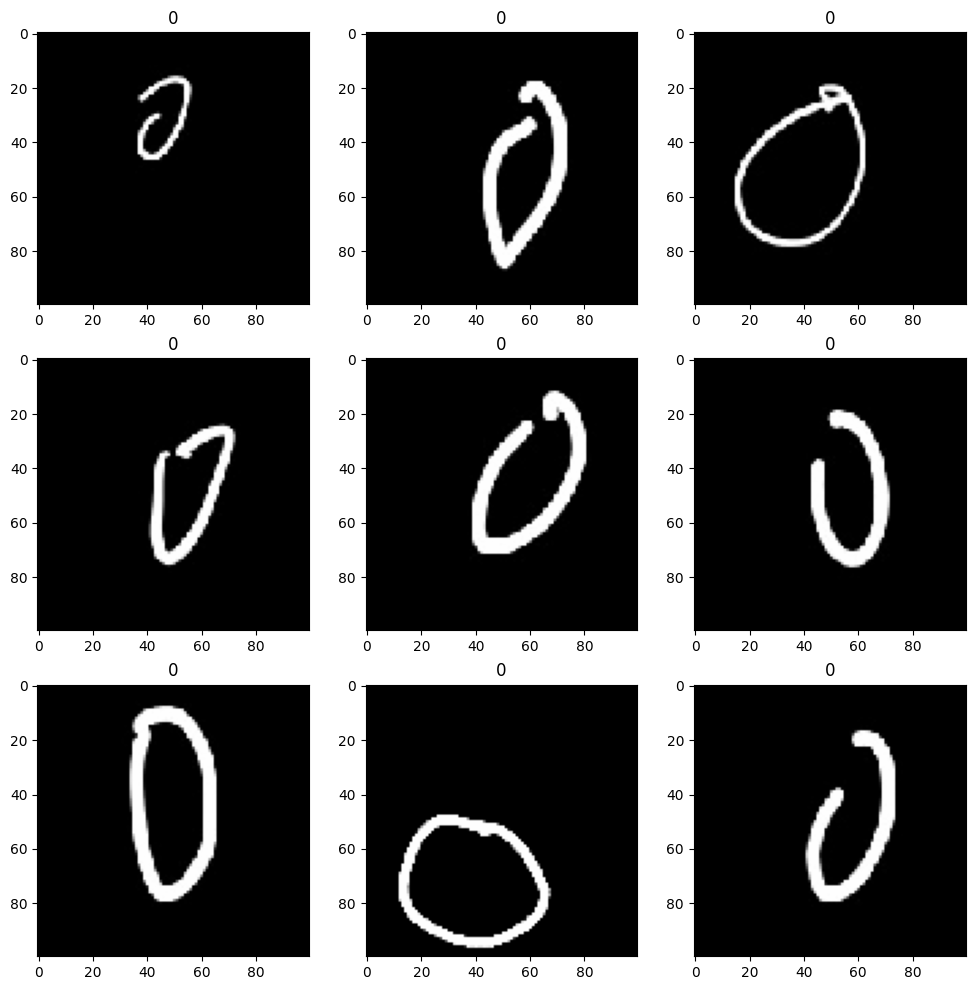

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in test_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        print(image.shape)
        label = class_labels[np.argmax(labels[i])]
        #plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        plt.imshow(image)
        plt.title(label)
    break

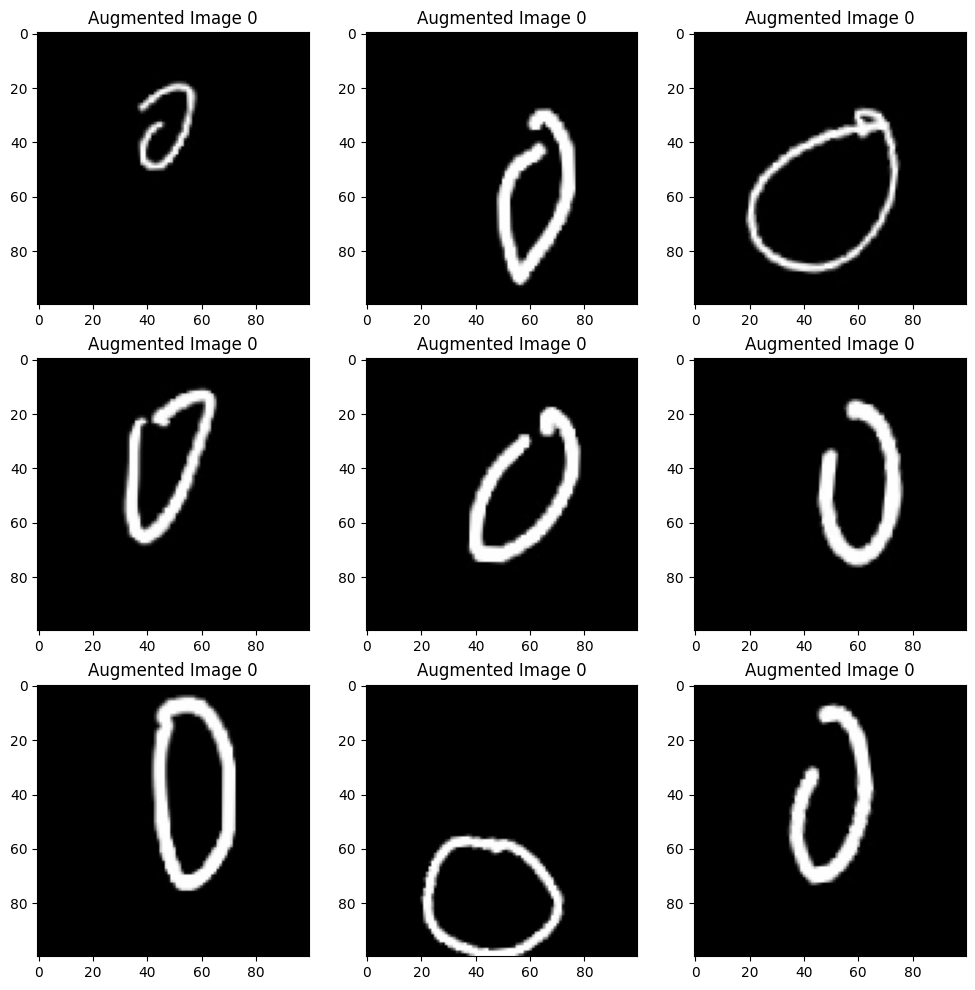

In [13]:
plt.figure(figsize=(12, 12))
for img_batch,label_batch in train_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]
        tx_img = traindata_gen.random_transform(image)
        plt.imshow(tx_img, cmap='gray', vmin=0, vmax=1)
        plt.title('Augmented Image ' + label)
        
    break

In [9]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=image_shape, pooling='max', weights='imagenet') 
base_model.trainable = False
x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

x=Dropout(rate=.3, seed=123)(x)         

output=Dense(num_classes, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])  

early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=2, verbose=1,restore_best_weights=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']           

In [11]:
result = model.fit(
  train_set,
  epochs=epochs,
  validation_data=val_set,
  callbacks=[early_stop]
    
)

Epoch 1/8
225/225 [==============================] - 87s 358ms/step - loss: 10.7524 - accuracy: 0.8515 - val_loss: 5.6185 - val_accuracy: 0.9239
Epoch 2/8
225/225 [==============================] - 40s 178ms/step - loss: 3.4553 - accuracy: 0.9297 - val_loss: 1.9782 - val_accuracy: 0.9273
Epoch 3/8
225/225 [==============================] - 39s 172ms/step - loss: 1.3386 - accuracy: 0.9355 - val_loss: 0.8828 - val_accuracy: 0.9407
Epoch 4/8
225/225 [==============================] - 39s 171ms/step - loss: 0.7344 - accuracy: 0.9271 - val_loss: 0.6063 - val_accuracy: 0.9374
Epoch 5/8
225/225 [==============================] - 40s 177ms/step - loss: 0.5360 - accuracy: 0.9386 - val_loss: 0.4799 - val_accuracy: 0.9441
Epoch 6/8
225/225 [==============================] - 42s 189ms/step - loss: 0.4704 - accuracy: 0.9382 - val_loss: 0.4606 - val_accuracy: 0.9351
Epoch 7/8
225/225 [==============================] - 45s 202ms/step - loss: 0.4386 - accuracy: 0.9386 - val_loss: 0.4411 - val_accuracy

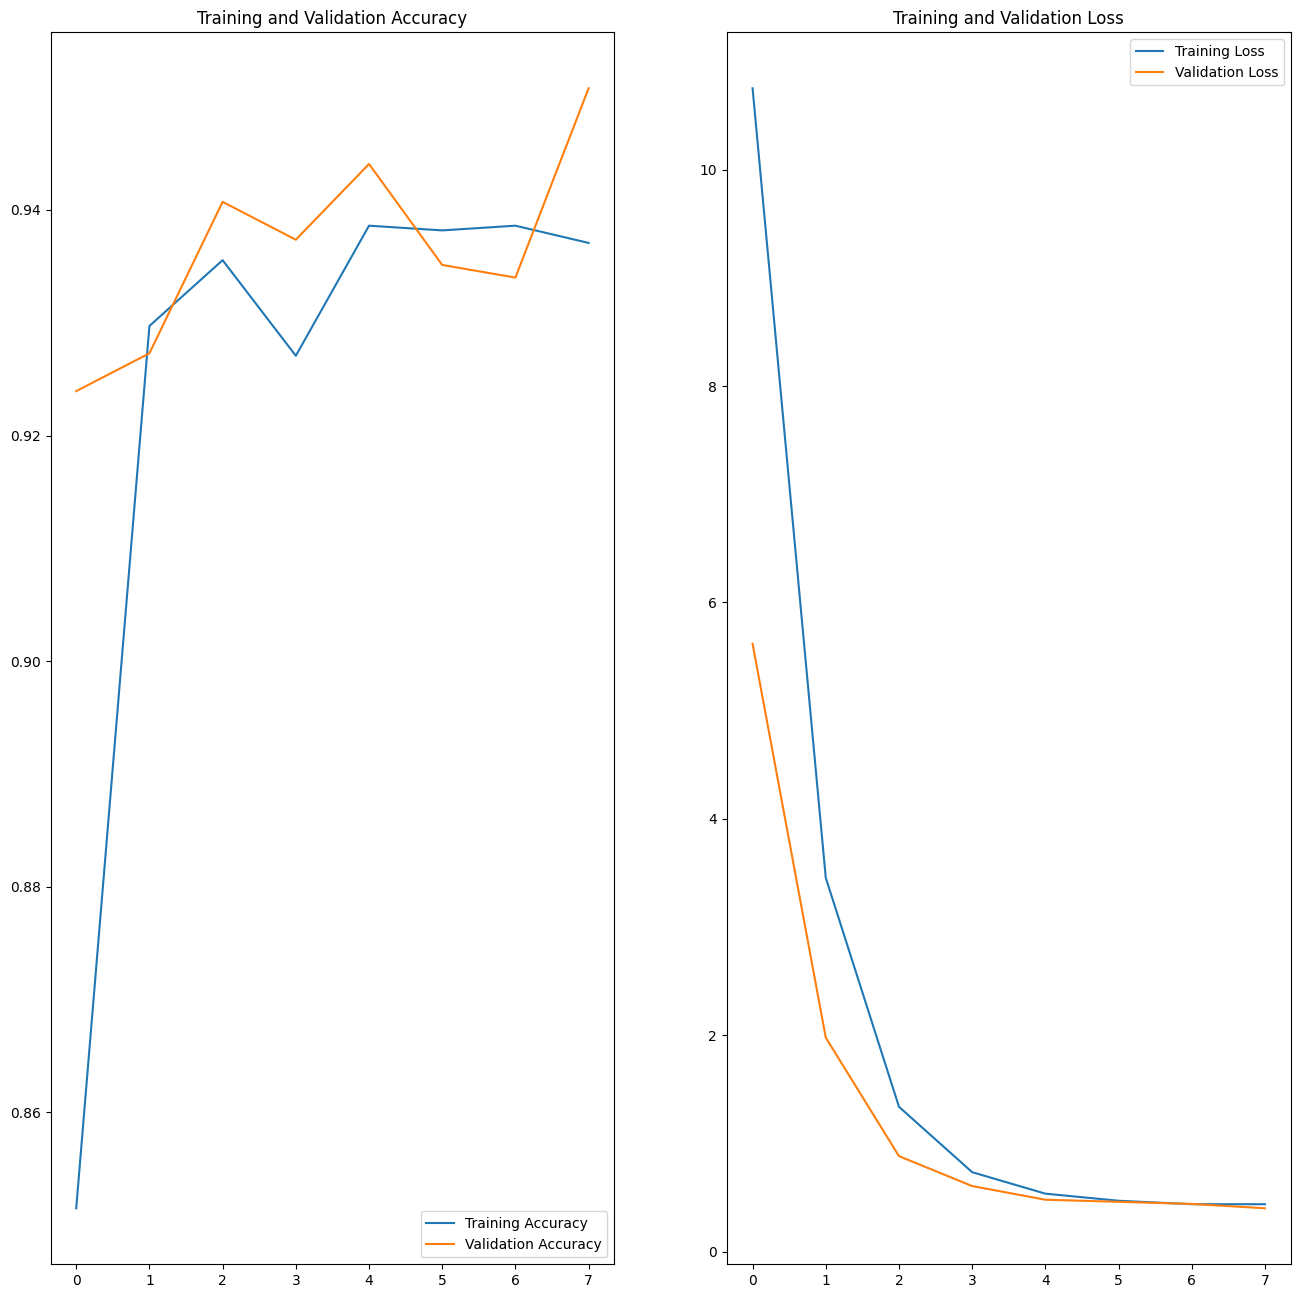

In [12]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())   

from sklearn.metrics import  classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

29/29 [==============================] - 7s 234ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        60
           1       0.96      0.96      0.96        57
           2       0.91      0.91      0.91        44
           3       0.87      0.85      0.86        55
           4       0.88      0.93      0.90        54
           5       0.82      0.95      0.88        44
           6       0.90      0.88      0.89        59
           7       0.91      0.93      0.92        54
           8       0.94      0.91      0.93        56
           9       1.00      0.91      0.95        56
         add       1.00      0.97      0.98        61
         dec       1.00      1.00      1.00        63
         div       0.97      1.00      0.98        63
          eq       1.00      0.97      0.98        64
         mul       1.00      0.97      0.98        59
         sub       0.99      1.00      0.99        66

    accuracy             

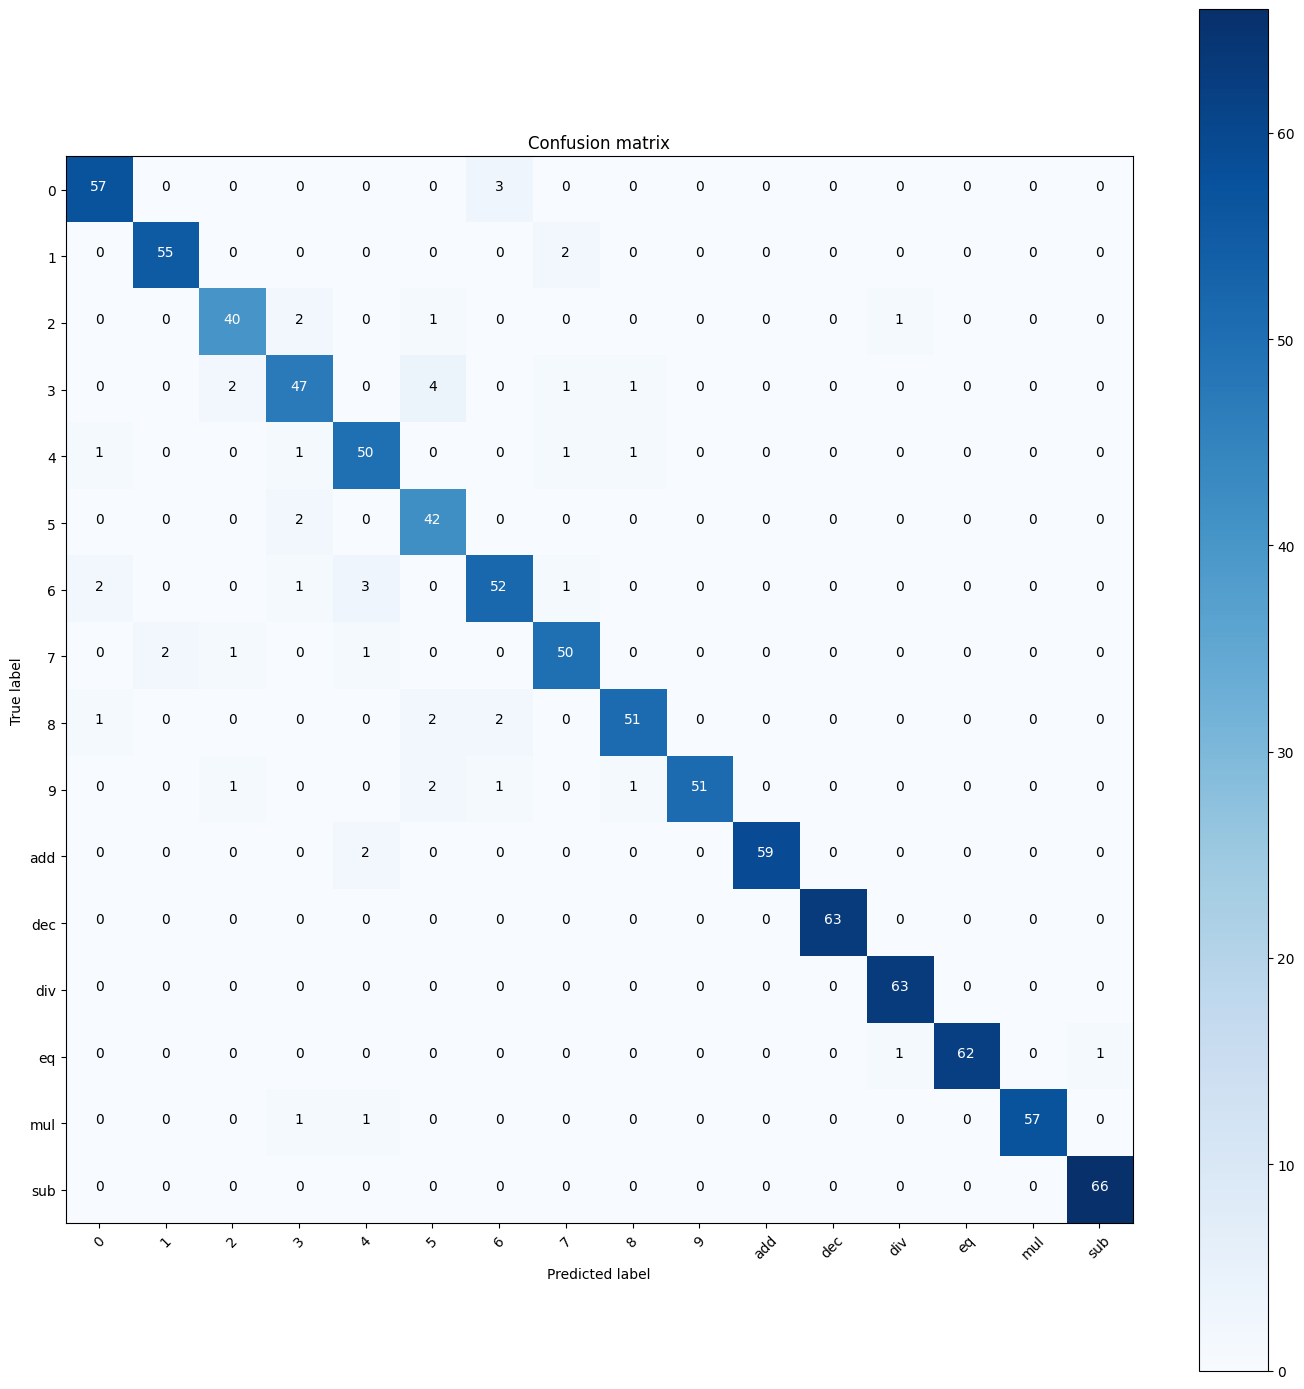

In [14]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix

plt.figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = class_labels) 

In [15]:
def grayscale_converted_image(image):
    converted = tf.image.rgb_to_grayscale((255 - np.array(image)) * 1 / 255.0)
    converted = tf.image.grayscale_to_rgb(converted)
    converted = tf.image.resize(converted, (image_shape[0], image_shape[1]))
    # plt.imshow(converted)
    input_arr = np.array([converted])
    return input_arr

image_path = '../projekat/characters/proba.png'
image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb')
input_arr = grayscale_converted_image(image)
predictions = model.predict(input_arr)

1/1 [==============================] - 1s 621ms/step


In [16]:
predictions

array([[6.2498093e-02, 2.7007831e-02, 4.4168689e-04, 1.1078812e-03,
        8.4455472e-01, 4.0367484e-04, 2.4161167e-03, 6.2522321e-04,
        2.9740548e-02, 1.3887187e-02, 1.1072929e-03, 9.7606350e-03,
        2.4543032e-03, 9.7275106e-04, 1.5982300e-03, 1.4238777e-03]],
      dtype=float32)

In [17]:
np.argmax(predictions, axis=-1)

array([4], dtype=int64)

In [18]:
class_labels[ np.argmax(predictions)]

'4'

In [19]:
def bob_prediction(image):
    input_arr = grayscale_converted_image(image)
    
    predicted_value = model.predict(input_arr)
    print(class_labels[ np.argmax(predicted_value)])
    
    return class_labels[ np.argmax(predicted_value) ]

In [20]:
def prediction(my_image, i):
    my_image = np.asarray(my_image)
    # my_image = img_to_array(my_image)   pretvara PIL u np.array
    my_image = cv2.resize(my_image, dsize=(image_shape[0], image_shape[1]))
    
    plt.subplot(2,2, i)
    plt.imshow(my_image)
    
    
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    
    # we need to change this 
    # my_image = preprocess_input(my_image)
    
#     print("Tip koji se predvidja: ",type(my_image))
    
    prediction = model.predict([my_image])
    
    
#     img = cv2.resize(img,(40, 40))
#     norm_image = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#     norm_image = norm_image.reshape((norm_image.shape[0], norm_image.shape[1], 1))
#     case = np.asarray([norm_image])
#     pred = model.predict_classes([case])
    # print(class_labels[ np.argmax([np.round(x) for x in prediction]) ])
    
    
#     print(prediction)
    print(class_labels[ np.argmax(prediction)])
    
    return class_labels[ np.argmax(prediction) ]

In [46]:
def merge_contours():
    bounding = 10
    global chars
    image = cv2.imread('../projekat/characters/proba3.png', 1)
    paper = cv2.resize(image, (800, 600))
    # paper = image.copy()
    img2 = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img2,(9,9),0) # apply blur for contour
    ret, thresh_gray = cv2.threshold(blur,228,255,cv2.THRESH_BINARY_INV) # apply threshold to blur image
    contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    figure = plt.figure(figsize=[16,12])
    plt.subplot(2, 1, 1)
    # https://stackoverflow.com/questions/18339988/implementing-imcloseim-se-in-opencv
    thresh_gray = cv2.morphologyEx(thresh_gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 40)));
    plt.imshow(thresh_gray, cmap='gray')
    
    # Find contours in thresh_gray after closing the gaps
    contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sort_contours(contours, method="left-to-right")[0]
    chars = []
    i = 0

    for c in contours:
        area = cv2.contourArea(c)
    
        (x, y, w, h) = cv2.boundingRect(c)
        # [bottom-left, top-left, top-right, bottom-right]
        
        # convert all coordinates floating point values to int
        (x, y, w, h) = np.intp([x, y, w, h])
        roi = paper[y - bounding:y + h + bounding, x - bounding:x + w +bounding]
        
        i += 1
        chars.append(bob_prediction(roi))
        cv2.rectangle(paper, (x-bounding, y-bounding), (x + w + bounding, y + h + bounding), (0, 255, 0), 2)
        # cv2.drawContours(paper, [box], 0, (0, 255, 0), 2)
        
    plt.subplot(2, 1, 2)
    plt.imshow(paper)
    # cv2.imshow('paper', paper)
    # cv2.imwrite('paper.jpg', paper)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
7
1/1 [==============================] - 0s 19ms/step
dec
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 21ms/step
eq
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 21ms/step
div
1/1 [==============================] - 0s 20ms/step
2


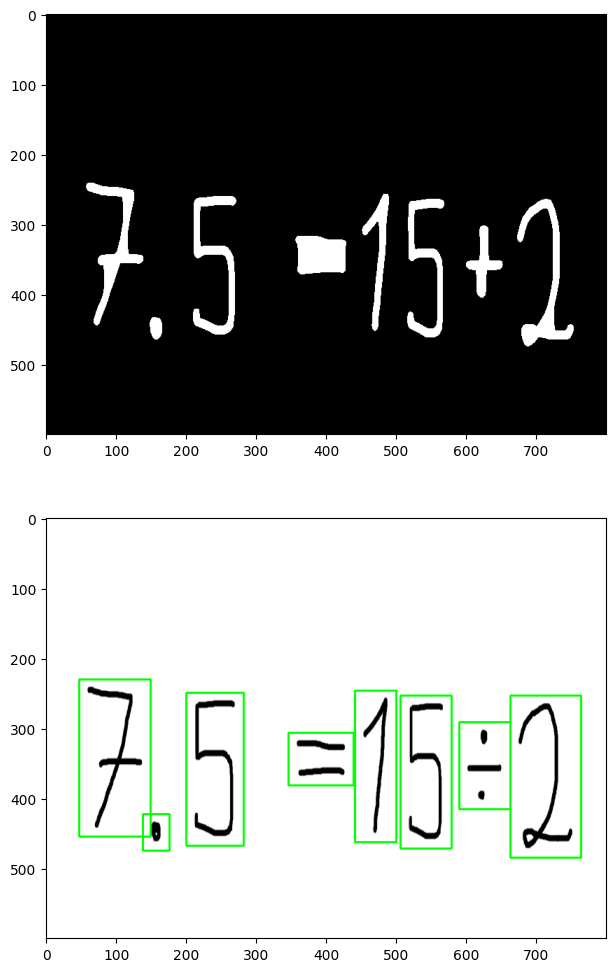

In [47]:
merge_contours()

In [48]:
operators = {
    'mul' : '*',
    'add' : '+',
    'sub' : '-',
    'div' : '/',
    'dec' : '.',
    'eq'  : '=='
 }

In [49]:
s = ''
for c in chars:
    if c in operators.keys():
        s += operators[c]
    else:
        s += c
print(eval(s))
print(s)

True
7.5==15/2


In [30]:
eval('2==3')

False

In [33]:
def kamera():
    bounding = 10
    global chars
    image = cv2.imread('../projekat/characters/wa4.jpeg', 1)
    paper = cv2.resize(image, (800, 600))
    # paper = image.copy()
    img2 = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)
    
   
    blur = cv2.GaussianBlur(img2,(9,9),0) # apply blur for contour
   
    # plt.imshow(blur, cmap='gray')
    
    ret, thresh_gray = cv2.threshold(blur,190,255,cv2.THRESH_BINARY_INV) # apply threshold to blur image
    # plt.imshow(thresh_gray, cmap='gray')
    contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    
    
    # https://stackoverflow.com/questions/18339988/implementing-imcloseim-se-in-opencv
    thresh_gray = cv2.morphologyEx(thresh_gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 30)));
    plt.imshow(thresh_gray, cmap='gray')
    
    # Find contours in thresh_gray after closing the gaps
    contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sort_contours(contours, method="left-to-right")[0]
    chars = []
    i = 0

    print(len(contours))
    for c in contours:
        area = cv2.contourArea(c)
        
        
        # print(area)
        (x, y, w, h) = cv2.boundingRect(c)
        # [bottom-left, top-left, top-right, bottom-right]
        
        # convert all coordinates floating point values to int
        (x, y, w, h) = np.intp([x, y, w, h])
        roi = paper[y - bounding:y + h + bounding, x - bounding:x + w +bounding]
        
        i += 1
        
        chars.append(bob_prediction(roi))
        cv2.rectangle(paper, (x-bounding, y-bounding), (x + w + bounding, y + h + bounding), (0, 255, 0), 2)
        # cv2.drawContours(paper, [box], 0, (0, 255, 0), 2)

    cv2.imshow('paper', paper)
    # cv2.imwrite('paper.jpg', paper)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

8
1/1 [==============================] - 0s 21ms/step
7
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 22ms/step
4
1/1 [==============================] - 0s 22ms/step
sub
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 19ms/step
div
1/1 [==============================] - 0s 19ms/step
2


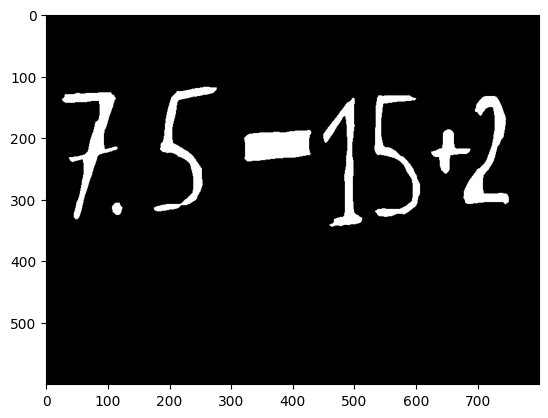

In [34]:
kamera()